# 1.Install Packages

In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import layers, Model

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 2.Remove dodgy images

In [3]:
import imghdr

C:\Users\sabar\AppData\Local\Temp\ipykernel_19400\336752527.py:1: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
data_dir = "fire_dataset"

In [5]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [6]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print(f"Image not in ext list {image_path}")
                os.remove(image_path)
        except Exception as e:
            continue

# 3.Load Data

In [7]:
data = tf.keras.utils.image_dataset_from_directory('fire_dataset')

Found 5540 files belonging to 2 classes.


In [8]:
data_iterator = data.as_numpy_iterator()

In [9]:
batch = data_iterator.next()

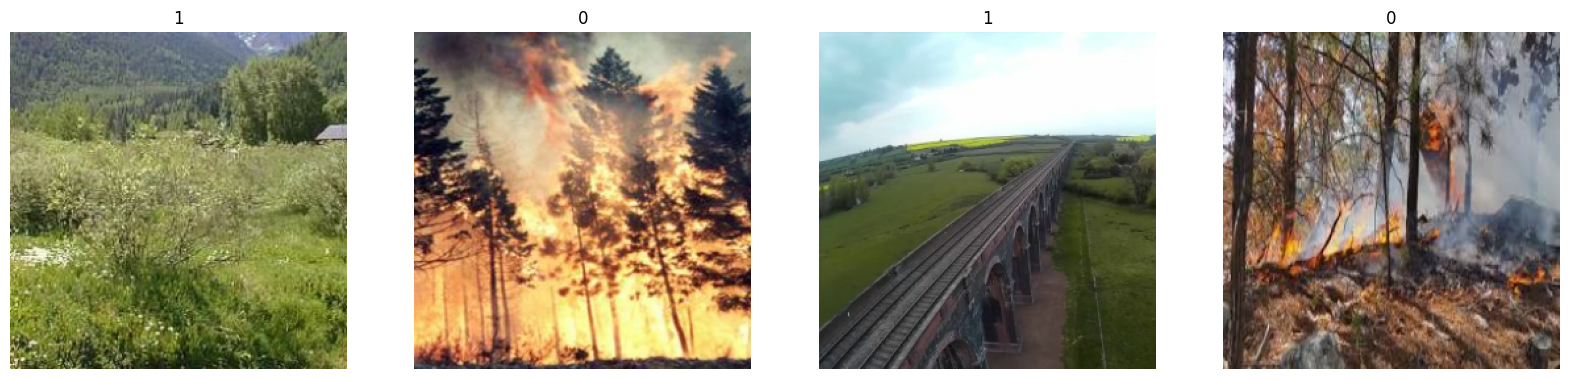

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    ax[idx].axis('off')
plt.show()

# 4.Scale/Normalising Data

In [11]:
data = data.map(lambda x, y: (x / 255.0, y))

# 5.Split Data

In [12]:
print('Total number of batches: {}'.format(len(data)))

Total number of batches: 31


In [13]:
train_size = int(len(data) * 0.7) + 1
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

In [14]:
print('train set: {} batches'.format(train_size))
print('val set: {} batches'.format(val_size))
print('test set: {} batches'.format(test_size))

train set: 22 batches
val set: 6 batches
test set: 3 batches


In [15]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [16]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# 6.Build Deep Learning Model

In [17]:
input_layer = layers.Input(shape=(256, 256, 3))

In [18]:
x = layers.Conv2D(16, (3, 3), activation='relu')(input_layer)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)

In [19]:
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

In [20]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7.Train Data

In [22]:
logdir = 'train_logs'

In [23]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [24]:
history = model.fit(train, epochs=25, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 494ms/step - accuracy: 0.7340 - loss: 0.5960 - val_accuracy: 0.8490 - val_loss: 0.3256
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 589ms/step - accuracy: 0.8843 - loss: 0.2583 - val_accuracy: 0.9479 - val_loss: 0.1398
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 602ms/step - accuracy: 0.9410 - loss: 0.1461 - val_accuracy: 0.9792 - val_loss: 0.0643
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 610ms/step - accuracy: 0.9632 - loss: 0.0988 - val_accuracy: 0.9219 - val_loss: 0.1532
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 532ms/step - accuracy: 0.9267 - loss: 0.1566 - val_accuracy: 0.9688 - val_loss: 0.1083
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 594ms/step - accuracy: 0.9549 - loss: 0.1123 - val_accuracy: 0.9271 - val_loss: 0.1934
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 655ms/step - accuracy: 0.9570 - loss: 0.1445 - val_accuracy: 0.9688 - val_loss: 0.0955
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 572ms/step - accuracy: 0.9525 - loss: 0.1116 - val_accu

# 8.Test Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


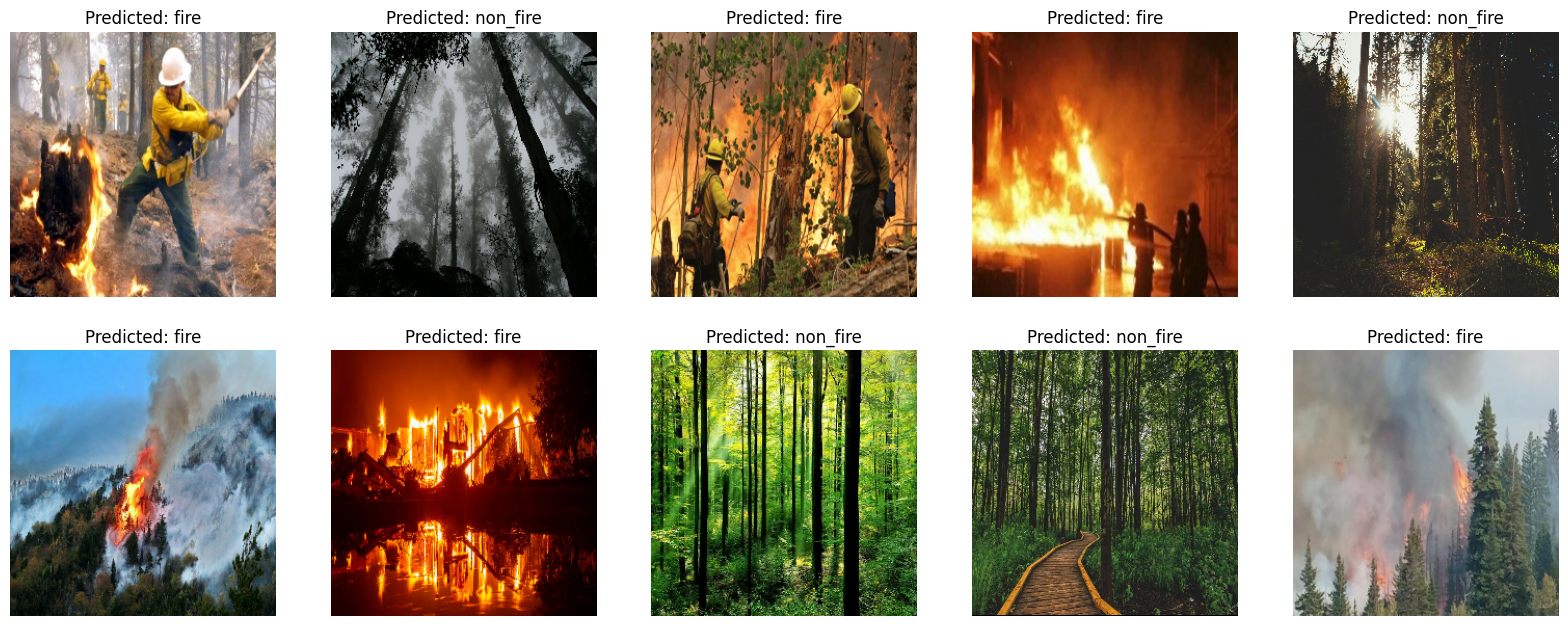

In [25]:

for images, labels in test.take(1):
    test_images = images[:10]
    test_labels = labels[:10]

predictions = model.predict(test_images)

def get_label_name(pred):
    return 'fire' if pred < 0.5 else 'non_fire'


plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Predicted: {get_label_name(predictions[i])}")
    plt.axis('off')
plt.show()

# 9.Evaluate

In [26]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [27]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [28]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


In [29]:
print(f'Precision: {pre.result()}')
print(f'Recall: {re.result()}')
print(f'Accuracy: {acc.result()}')

Precision: 1.0
Recall: 0.9629629850387573
Accuracy: 0.9895833134651184


# 10.Plot Performance

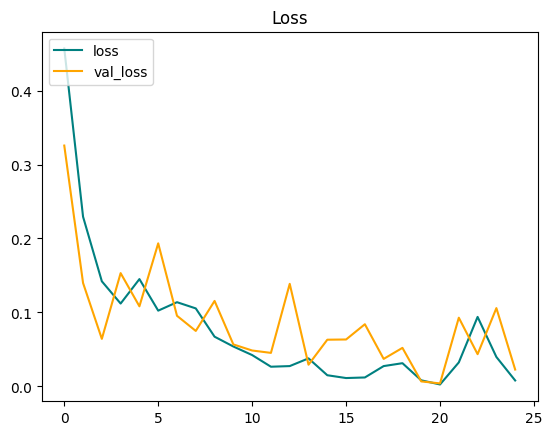

In [30]:
plt.figure()
plt.plot(history.history['loss'], label='loss', color='teal')
plt.plot(history.history['val_loss'], label='val_loss', color='orange')
plt.title('Loss')
plt.legend(loc='upper left')
plt.show()

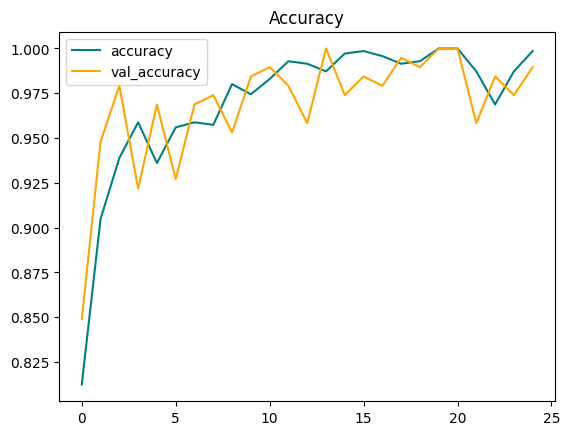

In [31]:
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy', color='teal')
plt.plot(history.history['val_accuracy'], label='val_accuracy', color='orange')
plt.title('Accuracy')
plt.legend(loc='upper left')
plt.show()

# 11.Custom Input

In [32]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = cv2.resize(img, (256, 256))  
    img = img / 255.0  
    img = np.expand_dims(img, axis=0) 
    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction: fire


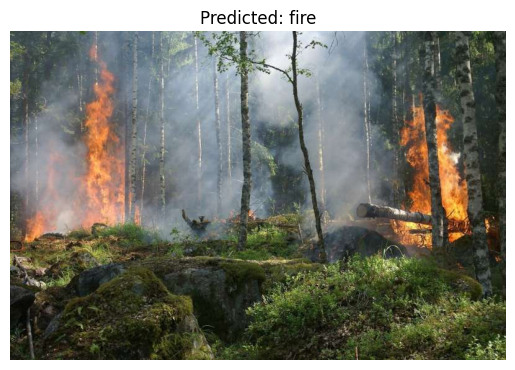

In [33]:
new_image_path = 'test_image.jpg'  
new_image = load_and_preprocess_image(new_image_path)
prediction = model.predict(new_image)

print(f"Prediction: {get_label_name(prediction[0][0])}")

plt.imshow(cv2.imread(new_image_path)[:, :, ::-1]) 
plt.title(f"Predicted: {get_label_name(prediction[0][0])}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction: non_fire


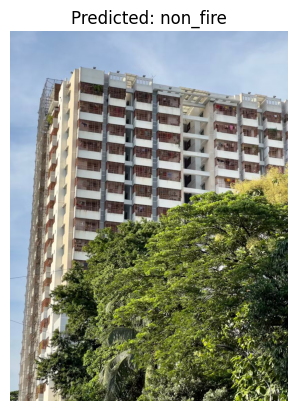

In [34]:
new_image_path = 'obj.jpg'  
new_image = load_and_preprocess_image(new_image_path)
prediction = model.predict(new_image)

print(f"Prediction: {get_label_name(prediction[0][0])}")

plt.imshow(cv2.imread(new_image_path)[:, :, ::-1]) 
plt.title(f"Predicted: {get_label_name(prediction[0][0])}")
plt.axis('off')
plt.show()